# Download the data
Data can be downloaded from https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation \
You can use the code below to download the data. First you need to download the API Token (kaggle.json) from the kaggle profile and place it in the current directory.


In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d faizalkarim/flood-area-segmentation

 87% 93.0M/107M [00:00<00:00, 126MB/s] 
100% 107M/107M [00:01<00:00, 102MB/s] 


In [2]:
%%capture
!unzip flood-area-segmentation.zip

# Install Packages

In [3]:
%%capture
!pip install livelossplot
!pip install kaggle
!pip install tensorflow_addons

# Imports

In [4]:
import glob
import os
import cv2
import pandas as pd
import numpy as np
from PIL import Image

import tensorflow as tf
import tensorflow_addons as tfa

from livelossplot.tf_keras import PlotLossesCallback

import matplotlib.pyplot as plt
%matplotlib inline

# Read and prepare data

Reading CSV with data. This CSV file contains the mapping of the image name to its mask.

In [5]:
img_path = './Image/'
mask_path = './Mask/'

df = pd.read_csv('./metadata.csv')
print(df.shape)
df.head()

(290, 2)


,Image,Mask
0,0.jpg,0.png
1,1.jpg,1.png
2,2.jpg,2.png
3,3.jpg,3.png
4,4.jpg,4.png


In [6]:
df.Image = df.Image.apply(lambda file_name: img_path + file_name)
df.Mask = df.Mask.apply(lambda file_name: mask_path + file_name)
df.head()

,Image,Mask
0,./Image/0.jpg,./Mask/0.png
1,./Image/1.jpg,./Mask/1.png
2,./Image/2.jpg,./Mask/2.png
3,./Image/3.jpg,./Mask/3.png
4,./Image/4.jpg,./Mask/4.png


For some reason some images are not read correctly.This function overwrites them for future use.

In [7]:
def overwriting_broken_image(image_name):
    image = np.asarray(Image.open(image_name))
    if len(image.shape) < 3:
        print(f'{image_name} is the broken image', )
        image = plt.imread(image_name) # Only plt.imread can read such an image. (I do not know why)
        plt.imsave(image_name, image)

for image in df.Image.values:
    overwriting_broken_image(image)

./Image/0.jpg is the broken image


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  warnings.warn(


./Image/3048.jpg is the broken image


Let's look at some images

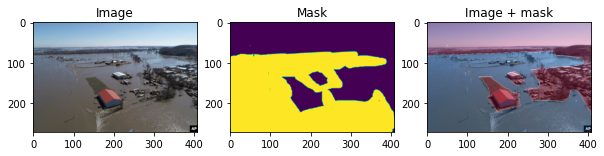

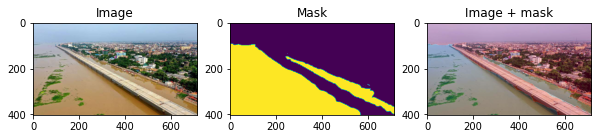

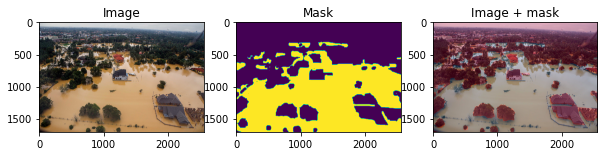

In [8]:
rand_indexes = np.random.choice(np.arange(df.shape[0]), 3)

for i, index in enumerate(rand_indexes):
    img = np.asarray(Image.open(df.Image.values[index])).astype(np.float32) / 255.
    mask = np.asarray(Image.open(df.Mask.values[index])).astype(np.float32) / 255.
    seg_mask = plt.get_cmap('RdBu')(mask)[..., :3]

    plt.figure(figsize=(10, 15))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title('Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.clip(img*0.8 + seg_mask*0.5, 0, 1))
    plt.title('Image + mask')

Validation split

In [9]:
def train_test_split(dataframe, train_size=0.9, shuffle=True):
    size = dataframe.shape[0]
    indexes = np.arange(size)
    if shuffle:
        np.random.shuffle(indexes)
    limit = int(size * train_size)
    train = dataframe.iloc[indexes[:limit], :] 
    test = dataframe.iloc[indexes[limit:], :] 
    return train, test

In [10]:
train_df, val_df = train_test_split(df, 0.9)
val_df, test_df = train_test_split(val_df, 0.6)

In [11]:
train_df.shape, val_df.shape, test_df.shape

((261, 2), (17, 2), (12, 2))

# Creating a data generator class

In [12]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, image_shape, batch_size, shuffle=False, augment=False, rescale=1):
        
        self.image_list = image_paths
        self.mask_list = mask_paths
        self.image_shape = image_shape
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.augment = augment
        self.rescale = rescale

        self.indexes = np.arange(len(self.image_list))
        
    def __len__(self):
        return len(self.image_list) // self.batch_size
    
    def __getitem__(self, index):
        x = []
        y = []
        for i in (self.indexes[index * self.batch_size: (index+1) * self.batch_size]):
            image = self._load_image_file(self.image_list[i], 'image') 
            mask = self._load_image_file(self.mask_list[i], 'mask') 
            image = tf.image.resize(image, self.image_shape).numpy()
            mask = tf.image.resize(mask, self.image_shape).numpy()
            x.append(image)
            y.append(mask)

        x = np.asarray(x) * self.rescale
        y = np.asarray(y) * self.rescale
        if self.augment:
            x, y = self._augmentation(x, y, rotation=True, rotation_range=2*np.pi,
                                      horizontal_flip=True, vertical_flip=True)
        return x, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    @staticmethod
    def _load_image_file(file_path, mode='image'):
        image = np.asarray(Image.open(file_path))
        if mode == 'image':
            image = image[:, :, :3]
        elif mode == 'mask':
            image = image[..., None]
        image = image.astype(np.float32)
        return image 
    
    def _augmentation(self, image, mask, rotation=False, rotation_range=0.0, 
                 horizontal_flip=False, vertical_flip=False):
        aug_image = image
        aug_mask = mask
        if rotation:
            aug_image, aug_mask = self._random_rotation(aug_image, aug_mask, rotation_range)
        if horizontal_flip:
            aug_image, aug_mask = self._random_horizontal_flip(aug_image, aug_mask)
        if vertical_flip:
            aug_image, aug_mask = self._random_vertical_flip(aug_image, aug_mask)
        return aug_image, aug_mask
    
    def _random_rotation(self, image, mask, rotation_range=np.pi/4):
        angle = np.random.uniform(low=0, high=rotation_range)
        return (tfa.image.rotate(image, angle, fill_mode='nearest'), 
                tfa.image.rotate(mask, angle, fill_mode='nearest'))
        
    def _random_horizontal_flip(self, image, mask):
        if np.random.randint(0, 2):
            return (tf.image.flip_up_down(image),
                    tf.image.flip_up_down(mask))
        else: return image, mask
    
    def _random_vertical_flip(self, image, mask):
        if np.random.randint(0, 2):
            return (tf.image.flip_left_right(image),
                    tf.image.flip_left_right(mask))
        else: return image, mask

In [13]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))

# Prepare U-Net model

In [21]:
IMAGE_SIZE = (768, 768)

def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size)

    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])
        previous_block_activation = x 

    for filters in [256, 128, 64, 32]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.UpSampling2D(2)(x)

        residual = tf.keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = tf.keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = tf.keras.layers.add([x, residual])  
        previous_block_activation = x 


    outputs = tf.keras.layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Build model
tf.keras.backend.clear_session()
model = get_model((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 384, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Train the model

In [22]:
BATCH_SIZE = 4
save_path = './models/'

X_train = DataGenerator(train_df.Image.values,
                        train_df.Mask.values,
                        image_shape=IMAGE_SIZE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        augment=True,
                        rescale=1/255.)

X_val  =  DataGenerator(val_df.Image.values,
                        val_df.Mask.values,
                        image_shape=IMAGE_SIZE,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        augment=False,
                        rescale=1/255.)

X_test = DataGenerator(test_df.Image.values,
                       test_df.Mask.values,
                       image_shape=IMAGE_SIZE,
                       batch_size=BATCH_SIZE,
                       shuffle=False,
                       augment=False,
                       rescale=1/255.)

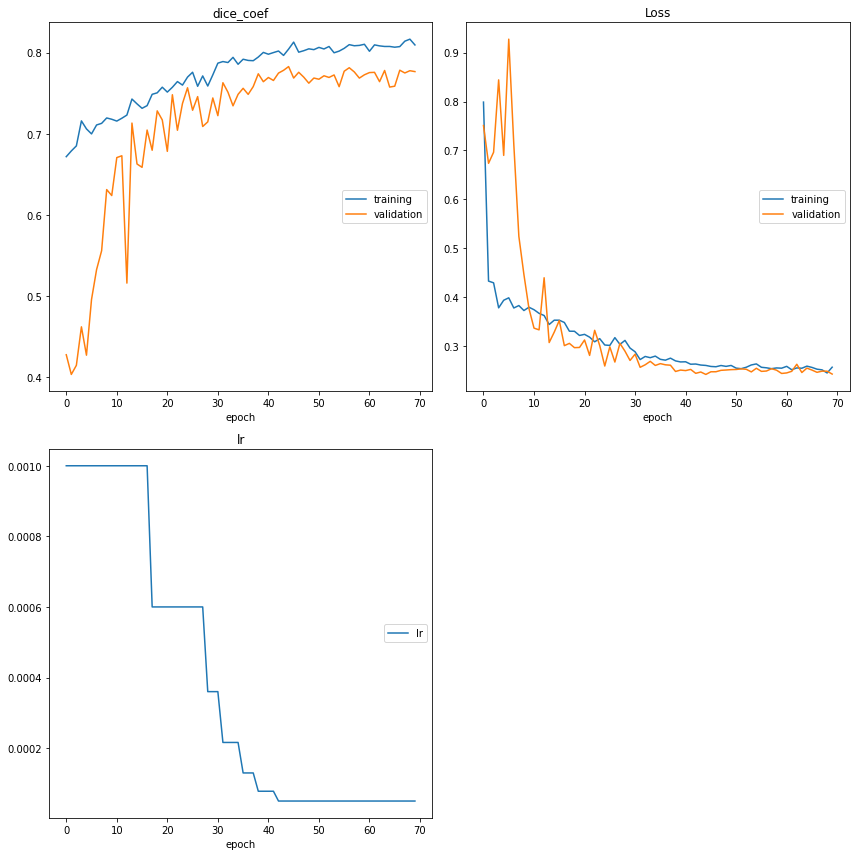

dice_coef
	training         	 (min:    0.672, max:    0.816, cur:    0.809)
	validation       	 (min:    0.404, max:    0.783, cur:    0.777)
Loss
	training         	 (min:    0.245, max:    0.799, cur:    0.257)
	validation       	 (min:    0.242, max:    0.928, cur:    0.243)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
65/65 [==============================] - 56s 871ms/step - loss: 0.2567 - dice_coef: 0.8094 - val_loss: 0.2427 - val_dice_coef: 0.7765 - lr: 5.0000e-05


In [23]:
EPOCHS = 70

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_path + 'best.h5',
                                                monitor='val_dice_coef',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coef',
                                                 factor=0.6,
                                                 patience=3,
                                                 mode='max',
                                                 min_lr=5e-5)

loss_plot = PlotLossesCallback()
callbacks = [checkpoint, reduce_lr, loss_plot]

model.compile(optimizer=optimizer, loss=loss, metrics=[dice_coef])
hist = model.fit(X_train,
                 validation_data=X_val,
                 verbose=1,
                 callbacks=callbacks,
                 epochs=EPOCHS)

In [31]:
model = tf.keras.models.load_model('./models/best.h5', custom_objects={'dice_coef': dice_coef})
model.evaluate(X_test)

1/3 [=========>....................] - ETA: 2s - loss: 0.2464 - dice_coef: 0.7856

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  warnings.warn(


3/3 [==============================] - 2s 270ms/step - loss: 0.2106 - dice_coef: 0.8127


[0.21061982214450836, 0.8127033710479736]

# Visualize predictions

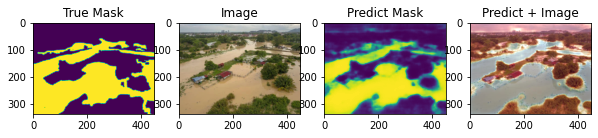

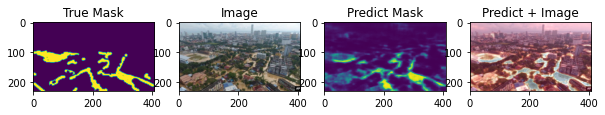

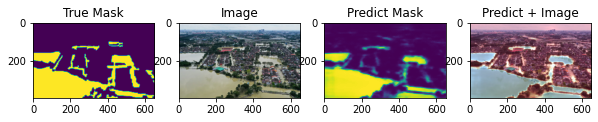

In [32]:
rand_indexes = np.random.choice(np.arange(test_df.shape[0]), 3)

for i, index in enumerate(rand_indexes):
    img = np.asarray(Image.open(test_df.Image.values[index])).astype(np.float32) / 255.
    mask = np.asarray(Image.open(test_df.Mask.values[index]))[..., None].astype(np.float32) / 255.
    weight, height = img.shape[:2]

    img = tf.image.resize(img, IMAGE_SIZE).numpy()
    mask = tf.image.resize(mask, IMAGE_SIZE).numpy()

    predict = model.predict(img[None, ...], verbose=0)[0, ...]
    seg_mask = plt.get_cmap('RdBu')(predict[..., 0])[..., :3]
    
    img = tf.image.resize(img, (weight, height)).numpy()
    mask = tf.image.resize(mask, (weight, height)).numpy()[..., 0]
    predict = tf.image.resize(predict, (weight, height)).numpy()[..., 0]
    seg_mask = tf.image.resize(seg_mask, (weight, height)).numpy()

    img_and_mask = np.clip(img*0.8 + seg_mask*0.5, 0, 1)

    plt.figure(figsize=(10, 15))
  
    plt.subplot(1, 4, 1)
    plt.title('True Mask')
    plt.imshow(mask)

    plt.subplot(1, 4, 2)
    plt.title('Image')
    plt.imshow(img)

    plt.subplot(1, 4, 3)
    plt.title('Predict Mask')
    plt.imshow(predict)

    plt.subplot(1, 4, 4)
    plt.title('Predict + Image')
    plt.imshow(np.clip(img*0.8 + seg_mask*0.5, 0, 1))
    plt.show()
